In [1]:
import os
import numpy as np
import scipy.ndimage
from PIL import Image
import scipy
import sys
from matplotlib import pyplot as plt
import urllib
import requests

exploring MnistHandler, MnistGenerator, and SortedNumberGenerator

In [2]:
class MnistHandler(object):

    ''' Provides a convenient interface to manipulate MNIST data '''

    def __init__(self):

        # Download data if needed
        self.X_train, self.y_train, self.X_val, self.y_val, self.X_test, self.y_test = self.load_dataset()

        # Load Lena image to memory
        self.lena = Image.open('../resources/lena.jpg')

    def load_dataset(self):
        # Credit for this function: https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py

        # We first define a download function, supporting both Python 2 and 3.
        if sys.version_info[0] == 2:
            from urllib import urlretrieve
        else:
            #from urllib.request import urlretrieve
            import requests

        def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
            print("Downloading %s" % filename)
            requests.get(source + filename, filename)

        # We then define functions for loading MNIST images and labels.
        # For convenience, they also download the requested files if needed.
        import gzip

        def load_mnist_images(filename):
            if not os.path.exists(filename):
                download(filename)
            # Read the inputs in Yann LeCun's binary format.
            with gzip.open(filename, 'rb') as f:
                data = np.frombuffer(f.read(), np.uint8, offset=16)
            # The inputs are vectors now, we reshape them to monochrome 2D images,
            # following the shape convention: (examples, channels, rows, columns)
            data = data.reshape(-1, 1, 28, 28)
            # The inputs come as bytes, we convert them to float32 in range [0,1].
            # (Actually to range [0, 255/256], for compatibility to the version
            # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
            return data / np.float32(256)

        def load_mnist_labels(filename):
            if not os.path.exists(filename):
                download(filename)
            # Read the labels in Yann LeCun's binary format.
            with gzip.open(filename, 'rb') as f:
                data = np.frombuffer(f.read(), np.uint8, offset=8)
            # The labels are vectors of integers now, that's exactly what we want.
            return data

        # We can now download and read the training and test set images and labels.
        X_train = load_mnist_images('../resources/train-images-idx3-ubyte.gz')
        y_train = load_mnist_labels('../resources/train-labels-idx1-ubyte.gz')
        X_test = load_mnist_images('../resources/t10k-images-idx3-ubyte.gz')
        y_test = load_mnist_labels('../resources/t10k-labels-idx1-ubyte.gz')

        # We reserve the last 10000 training examples for validation.
        X_train, X_val = X_train[:-10000], X_train[-10000:]
        y_train, y_val = y_train[:-10000], y_train[-10000:]

        # We just return all the arrays in order, as expected in main().
        # (It doesn't matter how we do this as long as we can read them again.)
        return X_train, y_train, X_val, y_val, X_test, y_test

    def process_batch(self, batch, batch_size, image_size=28, color=False, rescale=True):

        # Resize from 28x28 to 64x64
        if image_size == 64:
            batch_resized = []
            for i in range(batch.shape[0]):
                # resize to 64x64 pixels
                batch_resized.append(scipy.ndimage.zoom(batch[i, :, :], 2.3, order=1))
            batch = np.stack(batch_resized)

        # Convert to RGB
        batch = batch.reshape((batch_size, 1, image_size, image_size))
        batch = np.concatenate([batch, batch, batch], axis=1)

        # Modify images if color distribution requested
        if color:

            # Binarize images
            batch[batch >= 0.5] = 1
            batch[batch < 0.5] = 0

            # For each image in the mini batch
            for i in range(batch_size):

                # Take a random crop of the Lena image (background)
                x_c = np.random.randint(0, self.lena.size[0] - image_size)
                y_c = np.random.randint(0, self.lena.size[1] - image_size)
                image = self.lena.crop((x_c, y_c, x_c + image_size, y_c + image_size))
                image = np.asarray(image).transpose((2, 0, 1)) / 255.0

                # Randomly alter the color distribution of the crop
                for j in range(3):
                    image[j, :, :] = (image[j, :, :] + np.random.uniform(0, 1)) / 2.0

                # Invert the color of pixels where there is a number
                image[batch[i, :, :, :] == 1] = 1 - image[batch[i, :, :, :] == 1]
                batch[i, :, :, :] = image

        # Rescale to range [-1, +1]
        if rescale:
            batch = batch * 2 - 1

        # Channel last
        batch = batch.transpose((0, 2, 3, 1))

        return batch

    def get_batch(self, subset, batch_size, image_size=28, color=False, rescale=True):

        # Select a subset
        if subset == 'train':
            X = self.X_train
            y = self.y_train
        elif subset == 'valid':
            X = self.X_val
            y = self.y_val
        elif subset == 'test':
            X = self.X_test
            y = self.y_test

        # Random choice of samples
        idx = np.random.choice(X.shape[0], batch_size)
        batch = X[idx, 0, :].reshape((batch_size, 28, 28))

        # Process batch
        batch = self.process_batch(batch, batch_size, image_size, color, rescale)

        # Image label
        labels = y[idx]

        return batch.astype('float32'), labels.astype('int32')

    def get_batch_by_labels(self, subset, labels, image_size=28, color=False, rescale=True):

        # Select a subset
        if subset == 'train':
            X = self.X_train
            y = self.y_train
        elif subset == 'valid':
            X = self.X_val
            y = self.y_val
        elif subset == 'test':
            X = self.X_test
            y = self.y_test

        # Find samples matching labels
        idxs = []
        for i, label in enumerate(labels):

            idx = np.where(y == label)[0]
            idx_sel = np.random.choice(idx, 1)[0]
            idxs.append(idx_sel)

        # Retrieve images
        batch = X[np.array(idxs), 0, :].reshape((len(labels), 28, 28))

        # Process batch
        batch = self.process_batch(batch, len(labels), image_size, color, rescale)

        return batch.astype('float32'), labels.astype('int32')

    def get_n_samples(self, subset):

        if subset == 'train':
            y_len = self.y_train.shape[0]
        elif subset == 'valid':
            y_len = self.y_val.shape[0]
        elif subset == 'test':
            y_len = self.y_test.shape[0]

        return y_len



In [3]:
class MemmapHandler(object):
    ''' making and saving memmaps '''
    def __init__(self, folder, n_lags, spect_height, subset):
        # spect_height = number of freq. bins
        # y always has one time bin
        # n_lags is number of time bins of x
        # shape of x = (n_lags,spect_height) x number of samples
        # shape of y = (1, spect_height) x number of samples
        
        # input variables
        self.folder = folder  # either datafolder or visfolder
        self.n_lags = n_lags
        self.spect_height = spect_height
        self.subset = subset  # datafolder: use train/valid
                              # visfolder: use test
        
        # generated variables
        self.NIN = self.n_lags*self.spect_height
        data = self.init_data(folder, 'y.npy')
        self.num_data_samples = self.get_n_samples(self.subset)
        self.shape = (n_lags*spect_height, self.num_data_samples)
        
        
        def init_data(self, folder, name, data):
            ''' Create intitial stimulus and stimulus_vis memmaps '''
            from pathlib import Path
            data_file = Path(folder + name)
            
            if data_file.is_file():
                data = load_memmap(data)
            else:
                data = generate_memmap(data)
            return data
        
        def get_n_samples(self, data, subset):
            ''' function to get number of samples in subset '''
            if subset == 'train':
                return int(len(data) / self.spect_height)
            elif subset == 'valid':
                return int(len(data) / self.spect_height)
            elif subset == 'test':
                return int(len(data) / self.spect_height)
        
        def read_file_loc(self, folder, n_lags):
            ''' function to read in name of .dat file '''
            loc = '%sx_lag%03d.dat' % (folder, n_lags)
            return loc
        
        def generate_memmap(self, data, shape):
            new_map = np.memmap(data, dtype='float32', mode='r', shape=shape)
            return new_map
        
        def save_memmap(self, folder, filename, data):
            memmap = np.save(folder + filename, data)
            return memmap
            
        def load_memmap(self, data):
            saved_map = np.lib.format.open_memmap(data, dtype='float32', mode='r', shape=shape)
            return saved_map
            
        def memmap_copy(self, memmap_in, start_idx, end_idx):
            ''' function to copy memmap and save ram !! '''
            memmap_copy = memmap_in[:]
            subset = memmap_copy[start_idx, end_idx]
            return subset

In [4]:
# adapted for subset
class Shuffled_memmap_subset(object):
    
    ''' For creating train/valid/test shuffled memmap dataset '''
    
    def __init__(self, folder, subset, saved_data, vis_ratio=0, valid_ratio=.06):
        
        # Set params
        self.folder = folder
        self.subset = subset
        self.saved_data = saved_data  # filename as string, eg. 'data.npy'

        # Initialize memmap handler
        self.memmap_handler = MemmapHandler()
        
        # Initialize data
        data_loc = self.memmap_handler.read_file_loc(self.folder)
        data = self.memmap_handler.init_data(self.folder, self.saved_data, x_location)
        self.num_data_samples = self.memmap_handler.get_n_samples('train')
        self.dataset = data.memmap_copy(data, data.shape[0], data.shape[1][:1000])
    
        # get dataset+batching indicies
        #self.num_vis_samples = int(self.num_data_samples*vis_ratio)
        self.num_valid_samples = int(self.num_data_samples*valid_ratio)
        #vis_start = np.random.randint(self.num_data_samples - self.num_vis_samples)
       
        #self.vis_idxs = np.arange(vis_start, vis_start + self.num_vis_samples)
        #self.data_idxs = np.delete(np.arange(self.num_data_samples), self.vis_idxs)
        self.data_idxs_vis = np.arange(self.num_data_samples_vis)
        self.data_idxs = np.arange(self.num_data_samples)
        #self.num_data_samples -= self.num_vis_samples
       
        np.random.shuffle(self.data_idxs)
        self.valid_idxs, self.data_idxs = np.split(self.data_idxs, [self.num_valid_samples])
        self.num_data_samples -= self.num_valid_samples
    
    
    def get_num_samples(self, subset):
        ''' 
        Return number of samples wrt subset. 
            subset: a string - 'train', 'valid', or 'test'
        '''
        if subset == 'train':
            return self.num_data_samples
        elif subset == 'valid':
            return self.num_valid_samples
        elif subset == 'test':
            return self.num_data_samples_vis
    
    def get_data(self, idx):
        return self.x_data[:, idx].T, self.y_data[:, idx].T
   
    def data_iterator(self, batch_size=64):
        np.random.shuffle(self.data_idxs)
        for batch_idx in range(0, self.num_data_samples, batch_size):
            shuff_idx = self.data_idxs[batch_idx:batch_idx+batch_size]
            yield self.get_data(shuff_idx)
   
    def valid_set(self):
        return self.get_data(self.valid_idxs)
   
    def valid_iterator(self, batch_size=64):
        for batch_idx in range(0, self.num_valid_samples, batch_size):
            valid_idx = self.valid_idxs[batch_idx:batch_idx+batch_size]
            yield self.get_data(valid_idx)
   
    def vis_set(self):
        #return self.get_data(self.vis_idxs)
        return self.get_data(self.data_idxs_vis)
   
    #def vis_iterator(self, start=0, end=None, batch_size=1):
    #    if end is None:
    #        end = self.num_vis_samples
    #    for batch_idx in range(start, end, batch_size):
    #        data_idx = self.vis_idxs[batch_idx:batch_idx+batch_size]
    #        yield self.get_data(data_idx)
           
    def vis_iterator(self, start=0, end=None, batch_size=1):
        if end is None:
            end = self.num_data_samples_vis
        for batch_idx in range(start, end, batch_size):
            data_idx = self.data_idxs_vis[batch_idx:batch_idx+batch_size]
            yield self.get_data(data_idx)

In [5]:
class MnistGenerator(object):

    ''' Data generator providing MNIST data '''

    def __init__(self, batch_size, subset, image_size=28, color=False, rescale=True):

        # Set params
        self.batch_size = batch_size
        self.subset = subset
        self.image_size = image_size
        self.color = color
        self.rescale = rescale

        
        # Initialize MNIST dataset
        # init memmap batches here
        self.mnist_handler = MnistHandler()
        print(self.mnist_handler.get_n_samples(subset))
        self.n_samples = self.mnist_handler.get_n_samples(subset)
        self.n_batches = self.n_samples // batch_size
        print("samples: ", self.n_samples)
        print("batches: ", self.n_batches)

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return self.n_batches

    def next(self):

        # Get data
        x, y = self.mnist_handler.get_batch(self.subset, self.batch_size, self.image_size, self.color, self.rescale)
        
        # Convert y to one-hot
        y_h = np.eye(10)[y]
        print(x.shape, y_h.shape)
        print(y_h)

        return x, y_h

In [6]:
class SortedNumberGenerator(object):

    ''' Data generator providing lists of sorted numbers '''

    def __init__(self, batch_size, subset, terms, positive_samples=1, predict_terms=1, image_size=28, color=False, rescale=True):

        # Set params
        self.positive_samples = positive_samples
        self.predict_terms = predict_terms
        self.batch_size = batch_size
        self.subset = subset
        self.terms = terms
        self.image_size = image_size
        self.color = color
        self.rescale = rescale

        # Initialize MNIST dataset
        self.mnist_handler = MnistHandler()
        self.n_samples = self.mnist_handler.get_n_samples(subset) // terms
        self.n_batches = self.n_samples // batch_size

    def __iter__(self):
        return self

    def __next__(self):
        return self.next()

    def __len__(self):
        return self.n_batches

    def next(self):

        # Build sentences
        image_labels = np.zeros((self.batch_size, self.terms + self.predict_terms))
        sentence_labels = np.ones((self.batch_size, 1)).astype('int32')
        positive_samples_n = self.positive_samples
        for b in range(self.batch_size):

            # Set ordered predictions for positive samples
            seed = np.random.randint(0, 10)
            sentence = np.mod(np.arange(seed, seed + self.terms + self.predict_terms), 10)

            if positive_samples_n <= 0:

                # Set random predictions for negative samples
                # Each predicted term draws a number from a distribution that excludes itself
                numbers = np.arange(0, 10)
                predicted_terms = sentence[-self.predict_terms:]
                for i, p in enumerate(predicted_terms):
                    predicted_terms[i] = np.random.choice(numbers[numbers != p], 1)
                sentence[-self.predict_terms:] = np.mod(predicted_terms, 10)
                sentence_labels[b, :] = 0

            # Save sentence
            image_labels[b, :] = sentence

            positive_samples_n -= 1

        # Retrieve actual images (64, 64, 3) => (32, 2)
        # replace
        images, _ = self.mnist_handler.get_batch_by_labels(self.subset, image_labels.flatten(), self.image_size, self.color, self.rescale)
        print("actual images: ", images.shape)
        
        # Assemble batch
        images = images.reshape((self.batch_size, self.terms + self.predict_terms, images.shape[1], images.shape[2], images.shape[3]))
        x_images = images[:, :-self.predict_terms, ...]
        y_images = images[:, -self.predict_terms:, ...]
        print("images: ", images.shape)
        print("x_img: ", x_images.shape)
        print("y_img: ", y_images.shape)

        # Randomize
        idxs = np.random.choice(sentence_labels.shape[0], sentence_labels.shape[0], replace=False)
        print("idx shape: ", idxs.shape)
        #print("idx: ", idxs)
        print("sentence_labels shape: ", sentence_labels.shape)
        print("sentence_labels: ", sentence_labels)
        return [x_images[idxs, ...], y_images[idxs, ...]], sentence_labels[idxs, ...], idxs


testing *all* these objects

In [7]:
# Test MnistGenerator
mh, mx = MnistGenerator(batch_size=8, subset='train', image_size=28, color=False, rescale=True)

50000
samples:  50000
batches:  6250
(8, 28, 28, 3) (8, 10)
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
(8, 28, 28, 3) (8, 10)
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]
(8, 28, 28, 3) (8, 10)
[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


ValueError: too many values to unpack (expected 2)

In [14]:
# Test SortedNumberGenerator
ag = SortedNumberGenerator(batch_size=8, subset='train', terms=4, positive_samples=4, predict_terms=4, image_size=64, color=True, rescale=False)

actual images:  (64, 64, 64, 3)
images:  (8, 8, 64, 64, 3)
x_img:  (8, 4, 64, 64, 3)
y_img:  (8, 4, 64, 64, 3)
idx shape:  (8,)
sentence_labels shape:  (8, 1)
sentence_labels:  [[1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]]
actual images:  (64, 64, 64, 3)
images:  (8, 8, 64, 64, 3)
x_img:  (8, 4, 64, 64, 3)
y_img:  (8, 4, 64, 64, 3)
idx shape:  (8,)
sentence_labels shape:  (8, 1)
sentence_labels:  [[1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]]
actual images:  (64, 64, 64, 3)
images:  (8, 8, 64, 64, 3)
x_img:  (8, 4, 64, 64, 3)
y_img:  (8, 4, 64, 64, 3)
idx shape:  (8,)
sentence_labels shape:  (8, 1)
sentence_labels:  [[1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]]


ValueError: too many values to unpack (expected 2)

SortedNumberGenerator output 

In [9]:
len(ag)

1562

In [10]:
a = next(ag)

actual images:  (64, 64, 64, 3)
images:  (8, 8, 64, 64, 3)
x_img:  (8, 4, 64, 64, 3)
y_img:  (8, 4, 64, 64, 3)
idx shape:  (8,)
sentence_labels shape:  (8, 1)
sentence_labels:  [[1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]]


In [11]:
imgs = a[0]
img_lbls = a[1]

In [12]:
# shape of images (x)
np.vstack(imgs).shape

(16, 4, 64, 64, 3)

In [13]:
# shape of image labels (y)
np.vstack(img_lbls).shape

(8, 1)

In [15]:
imgs[0].shape

(8, 4, 64, 64, 3)

messing with train and validation sets in train_model()

In [16]:
#from data_utils import SortedNumberGenerator
from os.path import join, basename, dirname, exists
from tensorflow import keras
from tensorflow.keras import backend as K

### for examining output - don't reset this cell
train_model(
    epochs=10,
    batch_size=32,
    output_dir='models/64x64',
    code_size=128,
    lr=1e-3,
    terms=4,
    predict_terms=4,
    image_size=64,
    color=True
)

In [18]:
def network_encoder(x, code_size):

    ''' Define the network mapping images to embeddings '''

    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Conv2D(filters=64, kernel_size=3, strides=2, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dense(units=256, activation='linear')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.Dense(units=code_size, activation='linear', name='encoder_embedding')(x)

    return x


def network_autoregressive(x):

    ''' Define the network that integrates information along the sequence '''

    # x = keras.layers.GRU(units=256, return_sequences=True)(x)
    # x = keras.layers.BatchNormalization()(x)
    x = keras.layers.GRU(units=256, return_sequences=False, name='ar_context')(x)

    return x


def network_prediction(context, code_size, predict_terms):

    ''' Define the network mapping context to multiple embeddings '''

    outputs = []
    for i in range(predict_terms):
        outputs.append(keras.layers.Dense(units=code_size, activation="linear", name='z_t_{i}'.format(i=i))(context))

    if len(outputs) == 1:
        output = keras.layers.Lambda(lambda x: K.expand_dims(x, axis=1))(outputs[0])
    else:
        output = keras.layers.Lambda(lambda x: K.stack(x, axis=1))(outputs)

    return output


class CPCLayer(keras.layers.Layer):

    ''' Computes dot product between true and predicted embedding vectors '''

    def __init__(self, **kwargs):
        super(CPCLayer, self).__init__(**kwargs)

    def call(self, inputs):

        # Compute dot product among vectors
        preds, y_encoded = inputs
        dot_product = K.mean(y_encoded * preds, axis=-1)
        dot_product = K.mean(dot_product, axis=-1, keepdims=True)  # average along the temporal dimension

        # Keras loss functions take probabilities
        dot_product_probs = K.sigmoid(dot_product)

        return dot_product_probs

    def compute_output_shape(self, input_shape):
        return (input_shape[0][0], 1)


def network_cpc(image_shape, terms, predict_terms, code_size, learning_rate):

    ''' Define the CPC network combining encoder and autoregressive model '''

    # Set learning phase (https://stackoverflow.com/questions/42969779/keras-error-you-must-feed-a-value-for-placeholder-tensor-bidirectional-1-keras)
    K.set_learning_phase(1)

    # Define encoder model
    encoder_input = keras.layers.Input(image_shape)
    encoder_output = network_encoder(encoder_input, code_size)
    encoder_model = keras.models.Model(encoder_input, encoder_output, name='encoder')
    encoder_model.summary()

    # Define rest of model
    x_input = keras.layers.Input((terms, image_shape[0], image_shape[1], image_shape[2]))
    x_encoded = keras.layers.TimeDistributed(encoder_model)(x_input)
    context = network_autoregressive(x_encoded)
    preds = network_prediction(context, code_size, predict_terms)

    y_input = keras.layers.Input((predict_terms, image_shape[0], image_shape[1], image_shape[2]))
    y_encoded = keras.layers.TimeDistributed(encoder_model)(y_input)

    # Loss
    dot_product_probs = CPCLayer()([preds, y_encoded])

    # Model
    cpc_model = keras.models.Model(inputs=[x_input, y_input], outputs=dot_product_probs)

    # Compile model
    cpc_model.compile(
        optimizer=keras.optimizers.Adam(lr=learning_rate),
        loss='binary_crossentropy',
        metrics=['binary_accuracy']
    )
    cpc_model.summary()

    return cpc_model

#### no loss fxn
def train_model(epochs, batch_size, output_dir, code_size, lr=1e-4, terms=4, predict_terms=4, image_size=28, color=False):

    # Prepare data
    train_data = SortedNumberGenerator(batch_size=batch_size, subset='train', terms=terms,
                                       positive_samples=batch_size // 2, predict_terms=predict_terms,
                                       image_size=image_size, color=color, rescale=True)

    validation_data = SortedNumberGenerator(batch_size=batch_size, subset='valid', terms=terms,
                                            positive_samples=batch_size // 2, predict_terms=predict_terms,
                                            image_size=image_size, color=color, rescale=True)
    print("training set: ", len(train_data))
    print("validation set: ", len(validation_data))
    
    # Prepares the model
    model = network_cpc(image_shape=(image_size, image_size, 3), terms=terms, predict_terms=predict_terms,
                        code_size=code_size, learning_rate=lr)

    # Callbacks
    callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=2, min_lr=1e-4)]

    # Trains the model
    model.fit_generator(
        generator=train_data,
        steps_per_epoch=len(train_data),
        validation_data=validation_data,
        validation_steps=len(validation_data),
        epochs=epochs,
        verbose=1,
        callbacks=callbacks
    )

    # Saves the model
    # Remember to add custom_objects={'CPCLayer': CPCLayer} to load_model when loading from disk
    model.save(join(output_dir, 'cpc.h5'))

    # Saves the encoder alone
    encoder = model.layers[1].layer
    encoder.save(join(output_dir, 'encoder.h5'))

In [19]:
# loss fxn
def train_model(epochs, batch_size, output_dir, code_size, lr=1e-4, terms=4, predict_terms=4, image_size=28, color=False):

    # Prepare data
    train_data = SortedNumberGenerator(batch_size=batch_size, subset='train', terms=terms,
                                       positive_samples=batch_size // 2, predict_terms=predict_terms,
                                       image_size=image_size, color=color, rescale=True)

    validation_data = SortedNumberGenerator(batch_size=batch_size, subset='valid', terms=terms,
                                            positive_samples=batch_size // 2, predict_terms=predict_terms,
                                            image_size=image_size, color=color, rescale=True)
    print("train: ", len(train_data))
    #type(train_data).__name__
    print(np.shape(next(train_data)[0]))
    print(np.shape(next(train_data)[1]))
    print(np.shape(next(train_data)[2]))
    #print("validation: ", len(validation_data))
    #print(type(validation_data))
    
    # Prepares the model
    model = network_cpc(image_shape=(image_size, image_size, 3), terms=terms, predict_terms=predict_terms,
                        code_size=code_size, learning_rate=lr)

    # Callbacks
    history = keras.callbacks.History()
    reduce_LR_Plateau = keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=1/3, 
        patience=2, 
        min_lr=1e-4)
    #callbacks = [history, reduce_LR_Plateau]
    callbacks = [history]
    
    # Trains the model
    modeled = model.fit_generator(
        generator=train_data,
        steps_per_epoch=len(train_data),
        validation_data=validation_data,
        validation_steps=len(validation_data),
        epochs=epochs,
        verbose=1,
        callbacks=callbacks
    )

    # Saves the model
    # Remember to add custom_objects={'CPCLayer': CPCLayer} to load_model when loading from disk
    model.save(join(output_dir, 'cpc.h5'))

    # Saves the encoder alone
    encoder = model.layers[1].layer
    encoder.save(join(output_dir, 'encoder.h5'))
    
    # plotting loss
    train_loss = modeled.history['loss']
    val_loss = modeled.history['val_loss']
    epoch_count = range(1, epochs+1)    # 10 epochs

    plt.plot(epoch_count, train_loss, 'r--')
    plt.plot(epoch_count, val_loss, 'o-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.title('')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    t = time.localtime()
    timestamp = time.strftime('%b-%d-%Y_%H%M', t)
    plt.savefig(output_dir + "img/" + timestamp + ".png")

    return model


In [20]:
def find_ratio(train, val):
    ''' find train/validation set split '''
    total = train + val
    train_ratio = train/total
    val_ratio = val/total
    return "total training set: " + str(total), "training: " + str(train_ratio), "validation: " + str(val_ratio)

In [21]:
# finding training + validation set size
find_ratio(390, 78)

('total training set: 468',
 'training: 0.8333333333333334',
 'validation: 0.16666666666666666')

In [22]:
# finding test set size
test = SortedNumberGenerator(batch_size=8, subset='test', terms=4, positive_samples=4, predict_terms=4, image_size=64, color=True, rescale=False)
len(test)

312

In [23]:
# total data - if 28x28, should be 784 but is 780
# and is actually 64x64???
import math

dataset = 312 + 468   # 780 - from printing train_data and validation_data in train_model()
math.sqrt(dataset)

27.92848008753788

In [24]:
# train here - single GRU
train_model(
    epochs=5,
    batch_size=16,
    output_dir='../models/64x64',
    code_size=128,
    lr=1e-3,
    terms=4,
    predict_terms=4,
    image_size=64,
    color=True
)

train:  781
actual images:  (128, 64, 64, 3)
images:  (16, 8, 64, 64, 3)
x_img:  (16, 4, 64, 64, 3)
y_img:  (16, 4, 64, 64, 3)
idx shape:  (16,)
sentence_labels shape:  (16, 1)
sentence_labels:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
(2, 16, 4, 64, 64, 3)
actual images:  (128, 64, 64, 3)
images:  (16, 8, 64, 64, 3)
x_img:  (16, 4, 64, 64, 3)
y_img:  (16, 4, 64, 64, 3)
idx shape:  (16,)
sentence_labels shape:  (16, 1)
sentence_labels:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
(16, 1)
actual images:  (128, 64, 64, 3)
images:  (16, 8, 64, 64, 3)
x_img:  (16, 4, 64, 64, 3)
y_img:  (16, 4, 64, 64, 3)
idx shape:  (16,)
sentence_labels shape:  (16, 1)
sentence_labels:  [[1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]
(16,)
Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)          

AttributeError: 'SortedNumberGenerator' object has no attribute 'shape'

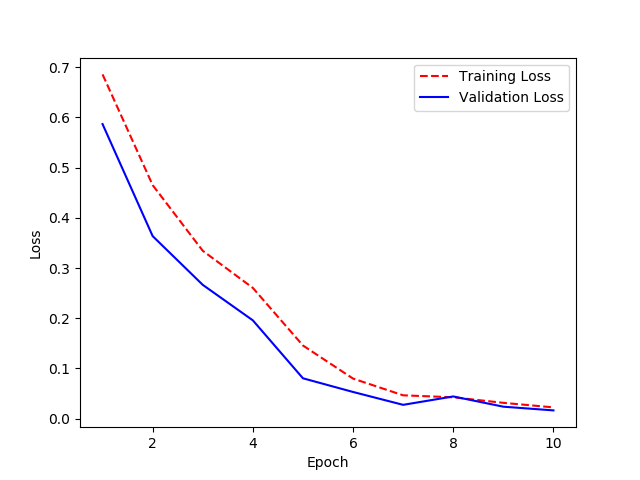

In [25]:
# display loss
import IPython
IPython.display.Image(filename="/home/AD/kachiem/github/contrastive-predictive-coding/models/64x64/loss/Nov-15-2019_0331.png") 